<a href="https://www.kaggle.com/code/danishyousuf19/deep-q-learning-for-ai-traffic-management-system?scriptVersionId=205007266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
np.random.seed(0)

In [ ]:
weather_conditions = {
    # Thunderstorms (higher impact due to reduced visibility and risk of accidents)
    "thunderstorm with light rain": 4, "thunderstorm with rain": 5, "thunderstorm with heavy rain": 6,
    "light thunderstorm": 3, "thunderstorm": 5, "heavy thunderstorm": 6, "ragged thunderstorm": 7,
    "thunderstorm with light drizzle": 4, "thunderstorm with drizzle": 5, "thunderstorm with heavy drizzle": 6,

    # Drizzle (low impact due to light precipitation)
    "light intensity drizzle": 1, "drizzle": 2, "heavy intensity drizzle": 3, "light intensity drizzle rain": 2,
    "drizzle rain": 3, "heavy intensity drizzle rain": 4, "shower rain and drizzle": 3, "heavy shower rain and drizzle": 4,
    "shower drizzle": 2,

    # Rain (moderate impact depending on intensity)
    "light rain": 2, "moderate rain": 3, "heavy intensity rain": 5, "very heavy rain": 6, "extreme rain": 7,
    "freezing rain": 8,  # Freezing rain is extremely hazardous
    "light intensity shower rain": 3, "shower rain": 4, "heavy intensity shower rain": 5, "ragged shower rain": 6,

    # Snow (high impact due to reduced traction, visibility)
    "light snow": 3, "snow": 5, "heavy snow": 7, "sleet": 6, "light shower sleet": 5, "shower sleet": 6, 
    "light rain and snow": 4, "rain and snow": 5, "light shower snow": 4, "shower snow": 6, "heavy shower snow": 7,

    # Atmospheric Conditions (varied impact)
    "mist": 1, "smoke": 3, "haze": 3,  # Mild impact on visibility
    "sand/dust whirls": 6, "fog": 4,  # Fog reduces visibility greatly
    "sand": 6, "dust": 5,  # Dust/sand can affect vehicle stability
    "volcanic ash": 8,  # Highly dangerous
    "squalls": 7,  # High winds combined with rain can be dangerous
    "tornado": 10  # Severe impact, total hazard
}


In [ ]:
time_of_day = {
    "Early Morning": 1, "Morning": 2, "Late Morning": 3, "Afternoon": 4, "Noon": 5, "Evening": 6, "Night": 7, "Late Night": 8
}

In [ ]:
def get_time_of_day_multiplier(time_of_day):
    multipliers = {
        1: (1.3, 1.4), 2: (1.6, 1.7), 3: (1.4, 1.5),
        4: (1.3, 1.4), 5: (1.4, 1.5), 6: (1.6, 1.7),
        7: (1.4, 1.5), 8: (1.3, 1.4)
    }
    return np.random.uniform(*multipliers.get(time_of_day, (1.0, 1.0)))


In [ ]:
def get_optimal_time(v, V, r, road_cond, unfair_cond):
    x = v + (V+.3*v)
    base_time = (x ** (1.7 / 2)) / math.sqrt(1/r)
    road_condition_multiplier = 1 + 0.5 * road_cond
    unfair_condition_multiplier = 1 + 0.85 * unfair_cond
    return base_time * road_condition_multiplier * unfair_condition_multiplier


In [ ]:
def calculate_vehicle_counts(n, ran_v, ran_V, tod_multiplier):
    lane_multiplier_0 = math.sqrt(math.pow((ran_v + 10e-2), math.log10((n + 10e-2)**1.2))) * ((n + 10e-2)**1.2)
    if n == 1:
        lane_multiplier_0 *= (ran_v + 10e-2)**0.5

    lane_multiplier_1 = math.sqrt(math.pow(ran_V, math.log10(n + 10e-2)) * n)+10e-3

    v = math.ceil(ran_v* lane_multiplier_0 * tod_multiplier * np.random.uniform(1.9, 1.94))
    V = int(ran_V * lane_multiplier_1 * tod_multiplier * np.random.uniform(0.7, 0.8))
#     print(f"lane_multiplier_0: {lane_multiplier_0}, lane_multiplier_1: {lane_multiplier_1}, ran_v: {ran_v}, ran_V: {ran_V}")

    return v, V

In [ ]:
def calculate_vehicle_gone(ot,pt,v):
    return int(v*(pt/ot))

In [ ]:
def calculate_reward(action, optimal_time):
    # Calculate thresholds as percentages of the optimal time
    threshold_1 = optimal_time * 0.1
    threshold_2 = optimal_time * 0.2
    threshold_3 = optimal_time * 0.3
    threshold_4 = optimal_time * 0.4
    threshold_5 = optimal_time * 0.5
    threshold_6 = optimal_time * 0.6
    
    difference = abs(action - optimal_time)

    if difference <= threshold_1:
        return 300  # Increase the reward for being within 10% of the optimal time
    elif difference <= threshold_2:
        return 100  # Increase the reward for being within 20% of the optimal time
    elif difference <= threshold_3:
        return 50   # Slightly higher reward for being within 30%
    elif difference <= threshold_4:
        return 20   # A little higher reward for being within 40%
    elif difference <= threshold_5:
        return -10  # Mild penalty for being within 50% of the optimal time
    elif difference <= threshold_6:
        return -50  # Slightly increased penalty for being within 60%
    else:
        return -250  # Reduced penalty for large errors to prevent overly negative rewards


In [ ]:
class DynamicEnv:
    def __init__(self, r, max_steps=30, model=None):
        self.r = r
        self.action_size = r
        self.feature_size =9
        self.state_size = r * self.feature_size
        self.road_pointer = 0
        self.weather_pointer = 0
        self.time_pointer = 0
        self.max_steps = max_steps
        self.time_track = []
        self.current_step = 0
        self.weather_conditions = list(weather_conditions.keys())
        self.time_of_day = list(time_of_day.keys())
        self.road_opening = np.zeros(r)

    def reset(self):
        print(f"S1 : Resetting the environment...")
        self.current_state = []
        curr_weather_cond_value = weather_conditions[self.weather_conditions[0]]
        curr_time_value = time_of_day[self.time_of_day[0]]
#         self.time_track = []
        # Initialize time of day multiplier
        tod_multiplier = get_time_of_day_multiplier(curr_time_value)

        n = np.random.randint(1, 5)

        for i in range(self.r):
            if i > 0:
                n_prev = self.current_state[(i - 1) * self.feature_size + 2]
                n = max(1, min(5, n_prev + np.random.randint(-1, 2)))

            ran_v = np.random.randint(1, 2)
            ran_V = np.random.randint(1, 2)
            v, V = calculate_vehicle_counts(n, ran_v, ran_V, tod_multiplier)
            unfair_cond = np.random.choice([0, 1], p=[0.94, 0.06])
            road_cond = np.random.choice([0, 1, 2], p=[0.65, 0.2, 0.15])

            # Update state with numeric values instead of strings
            road_state = [v, V, n, curr_weather_cond_value, curr_time_value, unfair_cond, road_cond,ran_v,ran_V]
            self.current_state.extend(road_state)

        state_array = np.array(self.current_state)
        print(f"S2 : Initial state after reset: {state_array}")
        return state_array

    def step(self, action,randM):
        print(f"S3 : Current state after step {self.current_step}: {self.current_state}")
#         print(f"S4 : Action taken  {action}")
        curr_weather_cond_value = weather_conditions[self.weather_conditions[self.weather_pointer]]
        curr_time_value = time_of_day[self.time_of_day[self.time_pointer]]
        tod_multiplier = get_time_of_day_multiplier(curr_time_value)

        # Extracting values for the selected road
        v = self.current_state[action * self.feature_size]
        V = self.current_state[action * self.feature_size + 1]
        n = self.current_state[action * self.feature_size + 2]
        road_cond = self.current_state[action * self.feature_size + 6]
        unfair_cond = self.current_state[action * self.feature_size + 5]
        ran_v= self.current_state[action * self.feature_size + 7]
        ran_V= self.current_state[action * self.feature_size + 8]
#         print(f"S4 : Current vehicles on road {action}: v={v}, V={V}")


        # Get optimal and predicted times
        optimal_time = get_optimal_time(v, V, n, road_cond, unfair_cond)
        if randM:
#             print("S5: Choosing optimal")
            predicted_time =get_optimal_time(v, V, n, road_cond, unfair_cond)
        else:
            predicted_time,_ = (self.predict_time(action))

        print(f"S6 : Optimal Time for road {action}: {optimal_time}, Predicted Time: {predicted_time}")
        self.time_track.append((predicted_time, optimal_time))

        v_g = calculate_vehicle_gone(optimal_time,predicted_time,v)
        V_g = calculate_vehicle_gone(optimal_time,predicted_time,V)
#         print(f"S7 : Gone vehicles from road {action}: v={v_g}, V={V_g}")
        # Update current state with new vehicle counts
        self.current_state[action * self.feature_size] = max(v - v_g, 0)
        self.current_state[action * self.feature_size + 1] = max(V - V_g, 0)

        # Calculate the reward
        reward = calculate_reward(predicted_time, optimal_time)

        self.current_step += 1

        # Update pointers for time and weather
        if self.current_step % 4 == 0:
            self.time_pointer = (self.time_pointer + 1) % len(self.time_of_day)
        if self.current_step % 7 == 0:
            self.weather_pointer = (self.weather_pointer + 1) % len(self.weather_conditions)

        # Update state for all roads
        for i in range(self.r):
            n = self.current_state[i * self.feature_size + 2]
            v_a, V_a = calculate_vehicle_counts(n,ran_v,ran_V, tod_multiplier)
            v_a=math.floor(v_a/1.4)
            V_a=math.floor(V_a/1.4)

#             print(f"Added vehicles to road {i}: v={v_a}, V={V_a}")
            self.current_state[i * self.feature_size] += v_a
            self.current_state[i * self.feature_size + 1] += V_a

            # Update the state with numeric values
            self.current_state[i * self.feature_size + 3] = weather_conditions[self.weather_conditions[self.weather_pointer]]
            self.current_state[i * self.feature_size + 4] = time_of_day[self.time_of_day[self.time_pointer]]
        
        done = self.current_step >= self.max_steps or optimal_time>300
#         print("DONE",done,"REWARDS",reward)
        if(done):
            self.current_step=0
        return np.array(self.current_state), reward, done

    def print_time_track(self):
        print("\nTime Tracking:")
        for predicted_time, actual_time in self.time_track:
            print(f"Predicted Time: {predicted_time}, Actual Time: {actual_time}")

    def predict_time(self, action):
        flattened_state = np.array(self.current_state).flatten()
        state = flattened_state[action * self.feature_size:(action + 1) * self.feature_size]
        state = state.reshape(1, -1)
        predicted_time = self.model.predict(state)
        predicted_time_scalar = predicted_time[0][0]
        v = self.current_state[action * self.feature_size]
        V = self.current_state[action * self.feature_size + 1]
        n = self.current_state[action * self.feature_size + 2]
        road_cond = self.current_state[action * self.feature_size + 6]
        unfair_cond = self.current_state[action * self.feature_size + 5]
        optimal_time = get_optimal_time(v, V, n, road_cond, unfair_cond)
        rewards_earned=calculate_reward(predicted_time, optimal_time)
#         print(f"Predicted time for road {action}: {predicted_time_scalar}")
#         print(f"Predicted time for road {action}: {rewards_earned}")

        return predicted_time_scalar,rewards_earned




In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, input_dim=9, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))  
    model.compile(loss='mse')
    return model


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, r):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.r = r
        self.current_road = 0
        self.gamma = 0.7
        self.epsilon = 0.9
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size =32
        self.model = build_model()
        self.target_model = build_model()
        self.update_target_model()

    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        print("Target model updated")

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        print("Memory Updated")

    def act(self, state):
        action = self.current_road
        print(f"Exploitation: Sequential action: Road {action}")
        self.current_road = (self.current_road + 1) % self.r  
        if np.random.rand() <= (self.epsilon/2):
            randM = True
        else: 
            randM = False  
        return action, randM

    def replay(self):
        if len(self.memory) < self.batch_size:
            print("Not enough samples to train")
            return

        # Sample a random batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in batch:
#             print("state action .. ", state, action, reward, next_state, done)
            target = 0
            
            if not done:
                # Reshape next_state to ensure it has the right dimensions
                next_state = np.array(next_state).astype(float).flatten()
                next_curr_state = next_state[action * 9:(action + 1) * 9] 
                next_curr_state = next_curr_state.reshape(1, -1)  
                next_predicted_time =self.target_model.predict(next_curr_state)
                target +=next_predicted_time
            # Predict the current Q-values for the current state
            flattened_state = np.array(state).flatten()
            curr_state = flattened_state[action * 9:(action + 1) * 9]
            curr_state = curr_state.reshape(1, -1)
            print(f"Predicting with curent state for road {action}: {curr_state}")
            curr_predicted_time= self.model.predict(curr_state)
            print(f"TARGET _F {curr_predicted_time}")
            print(f"TARGET {target}")
            curr_predicted_time[0] = target
#             Train the model to fit the target values
            self.model.fit(curr_state, curr_predicted_time, epochs=1, verbose=0)

        # Decay the exploration rate after every replay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [ ]:
if __name__ == "__main__":
    # Initialize the environment first
    env = DynamicEnv(r=4)

    # Pass the model to the agent after initializing the environment
    state_size = env.state_size
    action_size = env.action_size
    agent = DQNAgent(state_size, action_size, r=4)
    env.model = agent.model

    episodes = 14
    batch_size =32

    for e in range(episodes):
        state = env.reset()  # Reset the environment for the new episode
        state = np.reshape(state, [1, state_size])  # Reshape state

        done = False
        time = 0

        # Initialize lists to track times for the current episode
        

        while not done:
            action,randM = agent.act(state)  # Agent selects an action
            
            next_state, reward, done = env.step(action,randM)  # Step in the environment
            next_state = np.reshape(next_state, [1, state_size])  # Reshape next state
            agent.remember(state, action, reward, next_state, done)  # Store experience
            state = next_state  # Update state
            time += 1

            if done:
                print("UPDATING")
                agent.update_target_model()  # Update target model
                print("SAVING")
                agent.model.save(f"model_{e}.weights.h5")  # Save model weights
                print(f"Episode {e + 1}/{episodes}, time: {time}, score: {reward}")
                break

        if len(agent.memory) > batch_size:
            agent.replay()  
        if e % 2 == 0:
            print("UPDATING")
            agent.update_target_model()  # Update target model

        if e % 3 == 0:
            print("SAVING")

            agent.model.save(f"model_{e}.weights.h5")  # Save model weights

        # Collect predicted and optimal times for the episode
optimal_times = []
predicted_times = []
for predicted_time, optimal_time in env.time_track:
    predicted_times.append(predicted_time)
    optimal_times.append(optimal_time)


In [34]:
optimal_times

[10.096902569750487,
 48.41876503307982,
 84.54840326467806,
 63.0449124054044,
 29.81234369852314,
 73.70269158979308,
 164.30311100729597,
 68.78640069917745,
 23.510033492141133,
 88.79270714235943,
 102.61688603846457,
 118.83292101421851,
 22.554974664836955,
 145.1721726957119,
 175.684242735527,
 56.82533884788762,
 22.554974664836955,
 190.96301172466164,
 92.68623076439202,
 55.15540304482409,
 22.554974664836955,
 77.75539196666543,
 106.16078523171258,
 113.29830773301654,
 40.655362701719724,
 148.36210144955803,
 189.76151746629134,
 155.90770783174207,
 22.554974664836955,
 195.71891857060587,
 10.096902569750487,
 6.350534377250249,
 20.39788696174124,
 25.18331815685003,
 22.554974664836955,
 12.325542524545416,
 38.719903488661714,
 43.03567019988562,
 39.78980064657925,
 7.319448145887857,
 23.510033492141133,
 23.510033492141133,
 55.75459196546547,
 7.319448145887857,
 22.554974664836955,
 40.655362701719724,
 68.58257846898121,
 7.319448145887857,
 40.6553627017197

In [64]:
import plotly.graph_objs as go
import cufflinks as cf

# Enable offline mode for Cufflinks
cf.go_offline()

# Prepare the data for plotting
data = {
    'Predicted Times': predicted_times,
    'Optimal Times': optimal_times
}

# Create a DataFrame for better handling with Plotly
import pandas as pd

df = pd.DataFrame(data)

# Create a Plotly figure
fig = go.Figure()

# Add traces for predicted and optimal times
fig.add_trace(go.Scatter(x=df.index, y=df['Predicted Times'], mode='lines+markers', name='Predicted Times', marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['Optimal Times'], mode='lines+markers', name='Optimal Times', marker=dict(color='red')))

# Update layout
fig.update_layout(
    title=f'Episode {e + 1} - Time Comparison',
    xaxis_title='Time Step',
    yaxis_title='Time',
    legend_title='Legend',
    template='plotly_white',  # You can choose a different template if you want
    width=1500,  # Width of the figure
    height=600,  # Height of the figure
)

# Show the figure
fig.show()


In [69]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
df[::]

Predicted Times  Optimal Times
0           0.395572      10.096903
1          48.418765      48.418765
2           4.136400      84.548403
3          63.044912      63.044912
4          29.812344      29.812344
5          73.702692      73.702692
6         164.303111     164.303111
7           3.380298      68.786401
8          23.510033      23.510033
9           3.290097      88.792707
10          4.529335     102.616886
11        118.832921     118.832921
12         22.554975      22.554975
13          5.542696     145.172173
14        175.684243     175.684243
15         56.825339      56.825339
16         22.554975      22.554975
17        190.963012     190.963012
18         92.686231      92.686231
19          1.671374      55.155403
20          0.706040      22.554975
21          2.116659      77.755392
22          4.105185     106.160785
23          5.013701     113.298308
24         40.655363      40.655363
25          5.263547     148.362101
26          8.340775     189.761517
27          7.149074     155.907708
28          0.423032      22.554975
29        195.718919     195.718919
30         10.096903      10.096903
31         -0.947758       6.350534
32          0.286777      20.397887
33          0.692849      25.183318
34          1.423020      22.554975
35         12.325543      12.325543
36         38.719903      38.719903
37         43.035670      43.035670
38          2.916248      39.789801
39          7.319448       7.319448
40         23.510033      23.510033
41          1.274155      23.510033
42          4.334738      55.754592
43          7.319448       7.319448
44          0.996691      22.554975
45          2.735209      40.655363
46          5.319699      68.582578
47          7.319448       7.319448
48          2.560396      40.655363
49         55.754592      55.754592
50          6.247188      80.232136
51          7.319448       7.319448
52          3.984626      55.754592
53          0.930728      22.554975
54          7.151570      90.840285
55         -0.562070       7.319448
56          5.061416      69.369557
57         40.655363      40.655363
58          7.912585     100.497704
59         13.193312      13.193312
60         -0.107719       7.073334
61         30.806110      30.806110
62          0.775048      20.397887
63         -0.251300       9.423426
64         -0.168993      16.337407
65         45.109949      45.109949
66         38.719903      38.719903
67          0.486511      15.110588
68         24.703043      24.703043
69         45.109949      45.109949
70          1.159795      22.554975
71         20.433481      20.433481
72          0.049844      10.979172
73         45.109949      45.109949
74         40.655363      40.655363
75          0.650382       7.319448
76          1.174813      19.789968
77         47.020067      47.020067
78          1.642872      22.554975
79          1.155374      13.193312
80         27.933327      27.933327
81          1.506823      45.109949
82          2.900743      39.789801
83          1.511421      17.960586
84         10.979172      10.979172
85          2.887057      81.310725
86          4.036368      54.936435
87          1.897639      22.511525
88         10.979172      10.979172
89          4.091287     113.141271
90         -0.003948      17.601446
91         44.130232      44.130232
92         -0.347151      60.023211
93         76.353003      76.353003
94         -0.815674      60.270455
95         70.393468      70.393468
96        119.026647     119.026647
97         67.224567      67.224567
98         90.557190      90.557190
99         56.825339      56.825339
100        63.641875      63.641875
101        62.717553      62.717553
102        36.770269      36.770269
103        -0.056269      55.155403
104        59.649918      59.649918
105         0.250875      62.717553
106        36.770269      36.770269
107        -0.816781     103.581272
108        67.498744      67.498744
109       120.347875     120.347875
110      

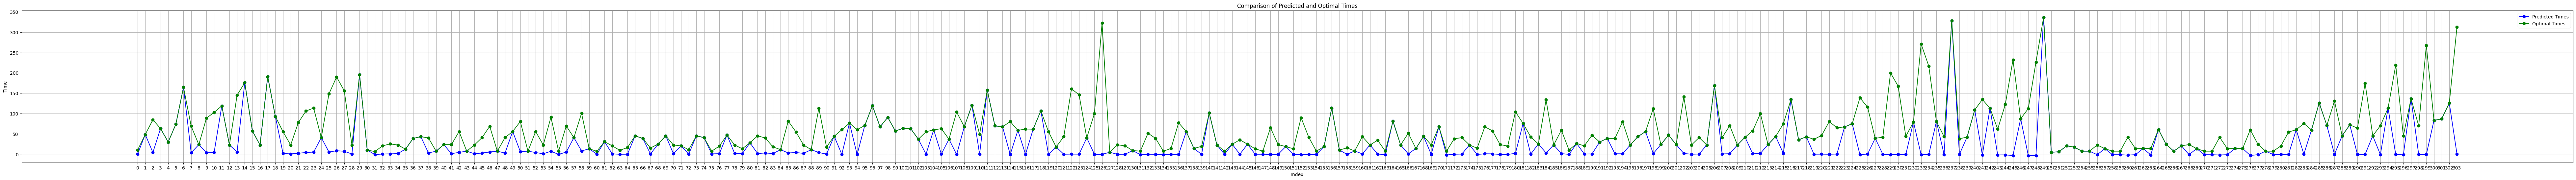

In [71]:
plt.figure(figsize=(100, 6))
plt.plot(predicted_times, marker='o', linestyle='-', color='b', label='Predicted Times')
plt.plot(optimal_times, marker='o', linestyle='-', color='g', label='Optimal Times')
plt.title('Comparison of Predicted and Optimal Times')
plt.xlabel('Index')
plt.ylabel('Time')
plt.xticks(range(len(predicted_times)))  # Setting x-ticks to match the index
plt.legend()
plt.grid()
plt.show()